In [60]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from bayes_opt import BayesianOptimization




In [61]:
# Load and prepare data
file_path = '/Users/schoudhry/Desktop/shashy/traderAuto/BRK.B(jan9.2024).csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Shared constants
initial_capital = 1000
initial_price = 468.0
shares_bought = initial_capital / initial_price

# --- STRATEGY 1: HUMAN RULES ---
human_buy_threshold = 498.5
human_sell_threshold = 502.5
cash, equity = 0, shares_bought
buys = sells = holds = 0
human_log = []

for _, row in df.iterrows():
    open_price = row['Open']
    if open_price < human_buy_threshold and cash > open_price:
        qty = cash // open_price
        cash -= qty * open_price
        equity += qty
        buys += 1
        action = f"BUY {qty} @ {open_price:.2f}"
    elif open_price > human_sell_threshold and equity >= 1:
        cash += equity * open_price
        action = f"SELL {equity} @ {open_price:.2f}"
        equity = 0
        sells += 1
    else:
        action = "HOLD"
        holds += 1
    human_log.append({
        'Date': row['Date'], 'Action': action, 'Cash': round(cash, 2),
        'Equity': round(equity, 4), 'Price': open_price
    })

final_val = cash + equity * df.iloc[-1]['Close']
human_summary = pd.DataFrame([{
    'Strategy': 'Human', 'Initial Capital': initial_capital, 'Buys': buys,
    'Sells': sells, 'Holds': holds, 'Buy Threshold': 498.5,'Sell Threshold': 502.5, 'Final Value': round(final_val, 2),
    'Profit': round(final_val - initial_capital, 2)
}])
human_log_df = pd.DataFrame(human_log)
human_log_df.to_csv("human_strategy_log.csv", index=False)

In [62]:
# --- STRATEGY 2: SCIKIT-LEARN REGRESSION ---
X = np.arange(len(df)).reshape(-1, 1)
y = df['Close'].values
model = LinearRegression().fit(X[:-1], y[1:])
predicted_close = model.predict(X)

cash, equity = 0, shares_bought
buys = sells = holds = 0
sklearn_log = []

for i, row in df.iterrows():
    open_price = row['Open']
    future_price = predicted_close[i]
    if future_price - open_price > 2 and cash > open_price:
        qty = cash // open_price
        cash -= qty * open_price
        equity += qty
        buys += 1
        action = f"BUY {qty} @ {open_price:.2f}"
    elif open_price - future_price > 2 and equity >= 1:
        cash += equity * open_price
        action = f"SELL {equity} @ {open_price:.2f}"
        equity = 0
        sells += 1
    else:
        action = "HOLD"
        holds += 1
    sklearn_log.append({
        'Date': row['Date'], 'Action': action, 'Cash': round(cash, 2),
        'Equity': round(equity, 4), 'Price': open_price
    })

final_val = cash + equity * df.iloc[-1]['Close']
sklearn_summary = pd.DataFrame([{
    'Strategy': 'Scikit-learn', 'Initial Capital': initial_capital, 'Buys': buys,
    'Sells': sells, 'Holds': holds, 'Final Value': round(final_val, 2),
    'Profit': round(final_val - initial_capital, 2)
}])
sklearn_log_df = pd.DataFrame(sklearn_log)
sklearn_log_df.to_csv("sklearn_strategy_log.csv", index=False)

# --- STRATEGY 3: AI-STYLE MOVING AVERAGE ---
df['SMA_short'] = df['Close'].rolling(window=5).mean()
df['SMA_long'] = df['Close'].rolling(window=20).mean()

cash, equity = 0, shares_bought
buys = sells = holds = 0
ai_log = []

for _, row in df.iterrows():
    open_price = row['Open']
    sma_short = row['SMA_short']
    sma_long = row['SMA_long']

    if pd.isna(sma_short) or pd.isna(sma_long):
        action = "HOLD"
        holds += 1
    elif sma_short > sma_long and cash > open_price:
        qty = cash // open_price
        cash -= qty * open_price
        equity += qty
        buys += 1
        action = f"BUY {qty} @ {open_price:.2f}"
    elif sma_short < sma_long and equity >= 1:
        cash += equity * open_price
        action = f"SELL {equity} @ {open_price:.2f}"
        equity = 0
        sells += 1
    else:
        action = "HOLD"
        holds += 1
    ai_log.append({
        'Date': row['Date'], 'Action': action, 'Cash': round(cash, 2),
        'Equity': round(equity, 4), 'Price': open_price
    })

final_val = cash + equity * df.iloc[-1]['Close']
ai_summary = pd.DataFrame([{
    'Strategy': 'AI Moving Avg', 'Initial Capital': initial_capital, 'Buys': buys,
    'Sells': sells, 'Holds': holds, 'Final Value': round(final_val, 2),
    'Profit': round(final_val - initial_capital, 2)
}])


In [63]:
ai_log_df = pd.DataFrame(ai_log)
ai_log_df.to_csv("ai_strategy_log.csv", index=False)

# Combine summaries
summary = pd.concat([human_summary, sklearn_summary, ai_summary])
print(summary)

        Strategy  Initial Capital  Buys  Sells  Holds  Buy Threshold  \
0          Human             1000     4      5    340          498.5   
0   Scikit-learn             1000    12     12    325            NaN   
0  AI Moving Avg             1000    12     13    324            NaN   

   Sell Threshold  Final Value  Profit  
0           502.5      1258.85  258.85  
0             NaN      1244.08  244.08  
0             NaN       852.92 -147.08  


In [ ]:

initial_capital = 1000
initial_price = 468.0
shares_bought = initial_capital / initial_price

# Define buy/sell threshold grid
buy_thresholds = np.arange(488.0, 495.5, 0.5)   # Lower limit close to historical lows
sell_thresholds = np.arange(500.5, 514.5, 0.5)  # Upper limit close to historical highs

# Store simulation results
results = []

for buy_thresh in buy_thresholds:
    for sell_thresh in sell_thresholds:
        cash, equity = 0, shares_bought
        for _, row in df.iterrows():
            open_price = row['Open']
            # Buy if price <= buy threshold
            if open_price <= buy_thresh and cash > open_price:
                qty = cash // open_price
                cash -= qty * open_price
                equity += qty
            # Sell if price >= sell threshold
            elif open_price >= sell_thresh and equity >= 1:
                cash += equity * open_price
                equity = 0
        final_value = cash + equity * df.iloc[-1]['Close']
        results.append({
            'Buy Threshold': round(buy_thresh, 2),
            'Sell Threshold': round(sell_thresh, 2),
            'Final Portfolio Value': round(final_value, 2),
            'Net Gain': round(final_value - initial_capital, 2)
        })

# Convert results to DataFrame and sort by best return
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Final Portfolio Value', ascending=False)

# Save top results
top_results = results_df.head(20)
#top_results.to_csv("top_aggressive_thresholds.csv", index=False)

# Print top 5
print(top_results.head())


In [ ]:

# Constants
initial_capital = 1000
initial_price = 468.0
shares_bought = initial_capital / initial_price

# Define trading simulation function for optimizer
def trading_profit(buy_threshold, sell_threshold):
    cash, equity = 0, shares_bought
    for _, row in df.iterrows():
        price = row['Open']
        if price <= buy_threshold and cash > price:
            qty = cash // price
            cash -= qty * price
            equity += qty
        elif price >= sell_threshold and equity >= 1:
            cash += equity * price
            equity = 0
    final_value = cash + equity * df.iloc[-1]['Close']
    return final_value - initial_capital

# Parameter bounds for optimizer
pbounds = {
    'buy_threshold': (488.0, 495.0),
    'sell_threshold': (500.5, 514.0)
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(
    f=trading_profit,
    pbounds=pbounds,
    random_state=42,
    verbose=2  # Display iteration details
)

optimizer.maximize(init_points=5, n_iter=25)

# Best threshold values
best_params = optimizer.max['params']
best_buy = best_params['buy_threshold']
best_sell = best_params['sell_threshold']

# Simulate with best thresholds
cash, equity = 0, shares_bought
buys = sells = holds = 0
trade_log = []

for _, row in df.iterrows():
    price = row['Open']
    if price <= best_buy and cash > price:
        qty = cash // price
        cash -= qty * price
        equity += qty
        action = f"BUY {qty} @ {price:.2f}"
        buys += 1
    elif price >= best_sell and equity >= 1:
        cash += equity * price
        action = f"SELL {equity} @ {price:.2f}"
        equity = 0
        sells += 1
    else:
        action = "HOLD"
        holds += 1
    trade_log.append({
        'Date': row['Date'],
        'Action': action,
        'Cash': round(cash, 2),
        'Equity': round(equity, 4),
        'Price': price
    })

# Final value and summary
final_value = cash + equity * df.iloc[-1]['Close']
profit = final_value - initial_capital

# Summary Table
bayes_summary = pd.DataFrame([{
    'Strategy': 'Bayesian Optimization',
    'Buy Threshold': round(best_buy, 2),
    'Sell Threshold': round(best_sell, 2),
    'Initial Capital': initial_capital,
    'Buys': buys,
    'Sells': sells,
    'Holds': holds,
    'Final Value': round(final_value, 2),
    'Profit': round(profit, 2)
}])

# Trade Log Table
trade_log_df = pd.DataFrame(trade_log)



# Save or print
print(bayes_summary)
print("\nTop of Trade Log:")
print(trade_log_df.head())
bayes_summary.to_csv("bayes_summary.csv", index=False)
trade_log_df.to_csv("bayes_trade_log.csv", index=False)


|   iter    |  target   | buy_th... | sell_t... |
-------------------------------------------------
| 1         | 254.0     | 490.6     | 513.3     |
| 2         | 292.1     | 493.1     | 508.6     |
| 3         | 158.3     | 489.1     | 502.6     |
| 4         | 204.8     | 488.4     | 512.2     |
| 5         | 254.0     | 492.2     | 510.1     |
| 6         | 292.1     | 495.0     | 508.1     |
| 7         | 254.0     | 495.0     | 514.0     |
| 8         | 258.0     | 495.0     | 505.0     |
| 9         | 254.0     | 495.0     | 510.4     |
| 10        | 258.0     | 492.7     | 506.7     |
| 11        | 248.8     | 495.0     | 500.5     |
| 12        | 254.0     | 492.6     | 514.0     |
| 13        | 292.1     | 494.0     | 507.8     |
| 14        | 292.1     | 494.1     | 508.8     |
| 15        | 273.4     | 495.0     | 507.0     |
| 16        | 186.3     | 488.0     | 507.7     |
| 17        | 248.8     | 495.0     | 502.8     |
| 18        | 292.1     | 493.7     | 508.3     |


,Strategy,Initial Capital,Buys,Sells,Holds,Buy Threshold,Sell Threshold,Final Value,Profit,Return (%)
0,Human,1000,4,5,340,498.50,502.50,1258.85,258.85,25.88
1,Scikit-learn,1000,12,12,325,NaN,NaN,1244.08,244.08,24.41
2,AI Moving Avg,1000,12,13,324,NaN,NaN,852.92,-147.08,-14.71
3,Bayesian Optimization,1000,3,4,342,493.12,508.58,1292.09,292.09,29.21


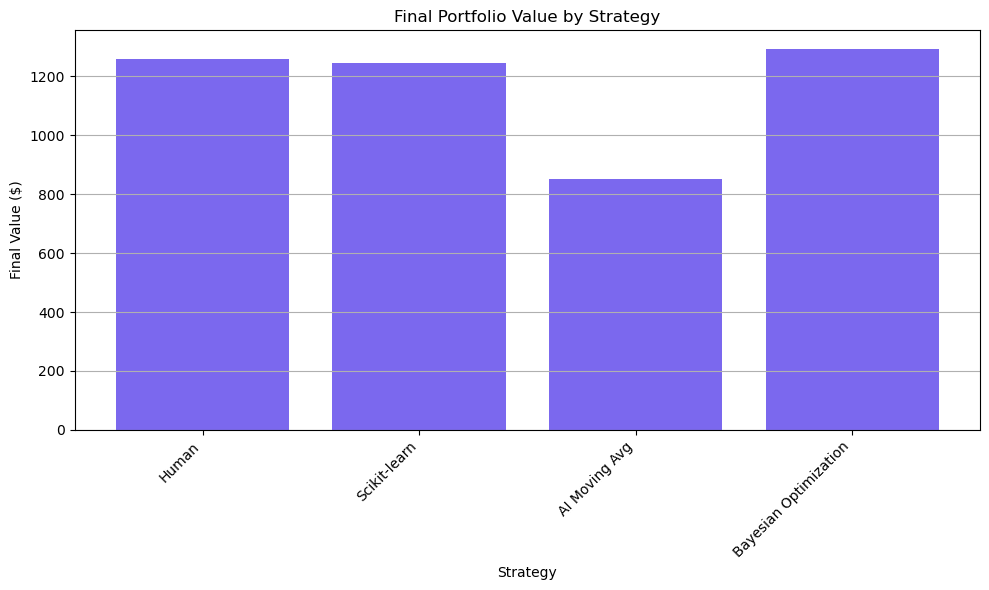

In [ ]:


# Combine all previously defined summary DataFrames (from each strategy block)
all_summaries = pd.concat([human_summary, sklearn_summary, ai_summary, bayes_summary], ignore_index=True)

# Add Return % for clarity
all_summaries['Return (%)'] = round(
    (all_summaries['Final Value'] - all_summaries['Initial Capital']) / all_summaries['Initial Capital'] * 100, 2
)

# Display the consolidated table
from IPython.display import display
display(all_summaries)

# Plot final value of each strategy
plt.figure(figsize=(10, 6))
plt.bar(all_summaries['Strategy'], all_summaries['Final Value'], color='mediumslateblue')
plt.title('Final Portfolio Value by Strategy')
plt.xlabel('Strategy')
plt.ylabel('Final Value ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
